<a href="https://colab.research.google.com/github/adityasingh1993/ML-DL-AI-LearnAndTry/blob/main/CV/VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
!ls

'bohemian-man-with-his-arms-crossed_1368-3542.jpg?w=1060'   me.jpg   sample_data  'url?sa=i'


In [ ]:
img=cv2.imread("me.jpg")
test_image=cv2.resize(img,(256,256))

In [ ]:

patches=tf.image.extract_patches(tf.expand_dims(img,axis=0),sizes=[1,16,16,1],strides=[1,16,16,1],rates=[1,1,1,1],padding="VALID")

In [ ]:
patches.shape

TensorShape([1, 85, 64, 768])

In [ ]:
84*63*3

15876

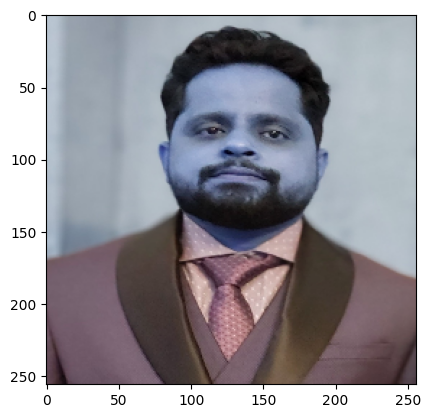

In [ ]:
plt.imshow(test_image)

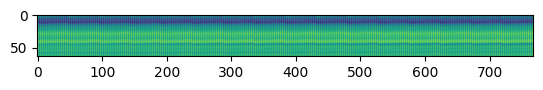

In [ ]:
plt.imshow(patches[0][0])

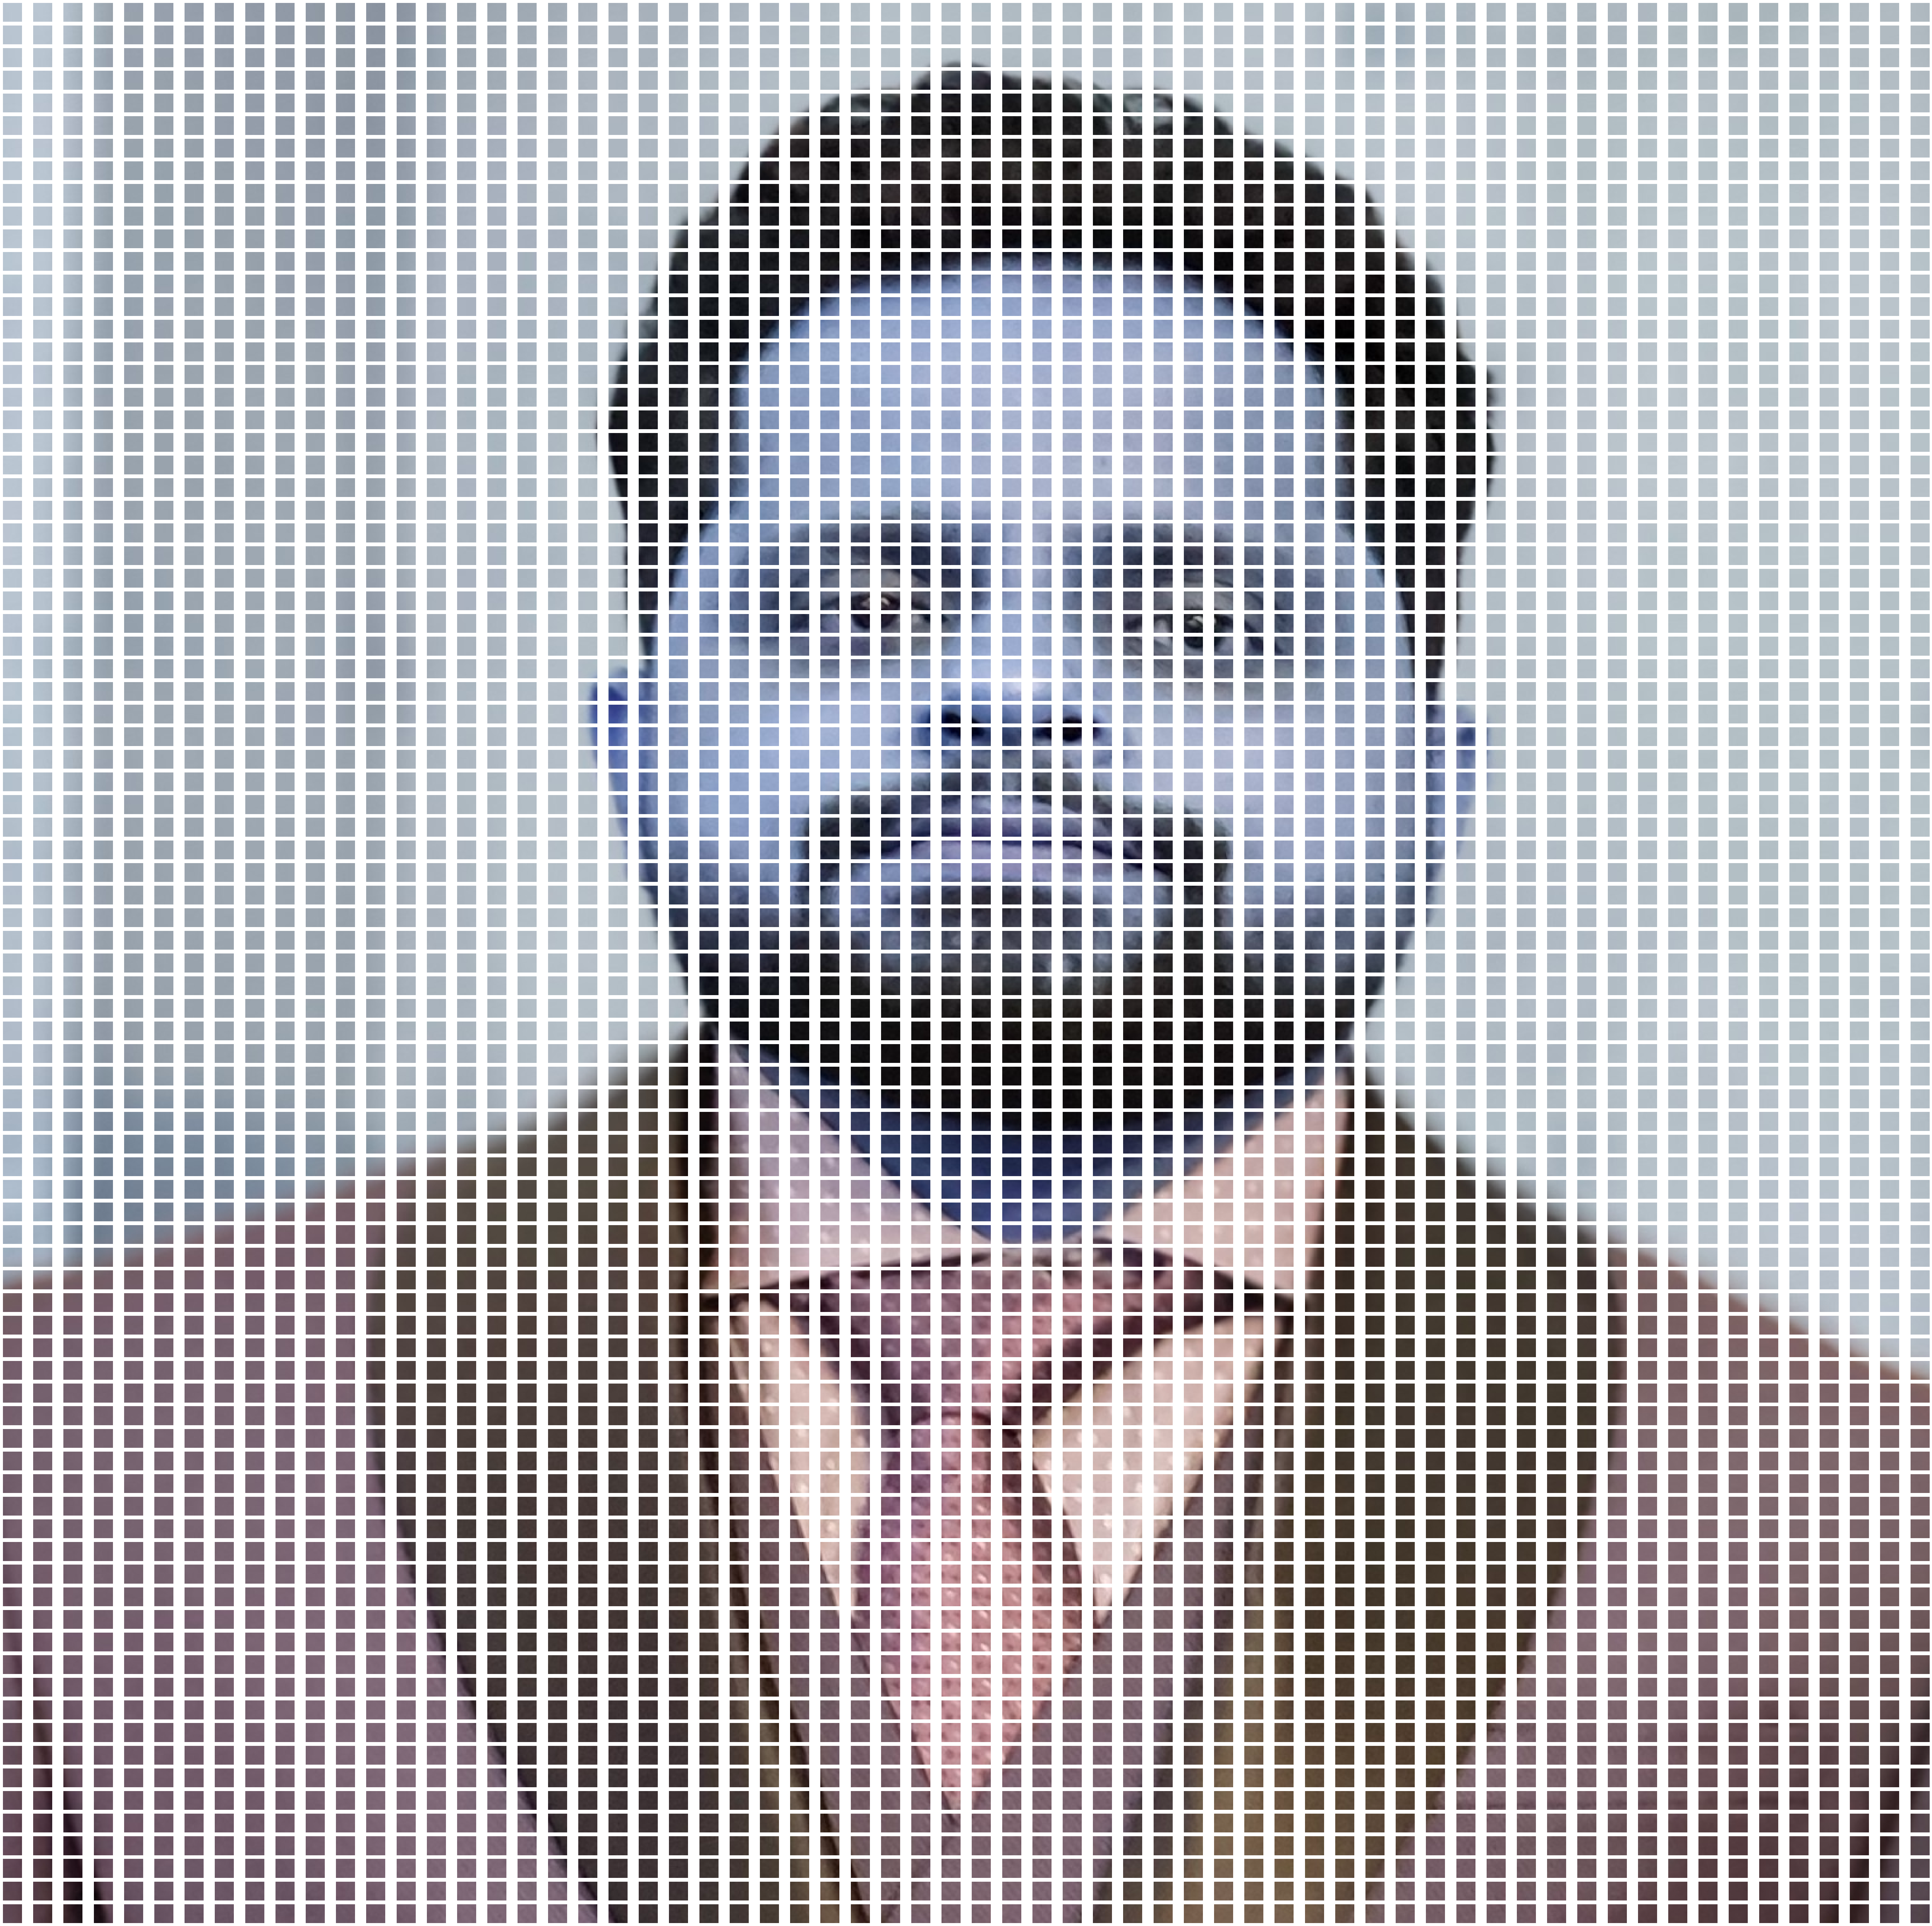

In [ ]:
plt.figure(figsize=(85,85))
k=0
for i in range(85):
  for j in range(64):
    ax=plt.subplot(85,64,k+1)
    plt.imshow(tf.reshape(patches[0,i,j,:],(16,16,3)))
    k+=1
    plt.axis("off")

In [ ]:
patches=tf.reshape(patches,(patches.shape[0],-1,768))

In [ ]:

class PatchEncoderLayer(tf.keras.Layer):
  def __init__(self,num_patches,projection_dim):
    super(PatchEncoderLayer,self).__init__(name="PatchEncoder")
    self.num_patches=num_patches
    self.projection=tf.keras.layers.Dense(units=projection_dim)
    #input_dim will be num of patches insteaqd of vocabulary
    self.embedding=tf.keras.layers.Embedding(input_dim=num_patches,output_dim=projection_dim)
  def call(self,x):
    patches=tf.image.extract_patches(x,sizes=[1,16,16,1],strides=[1,16,16,1],rates=[1,1,1,1],padding="VALID")

    self.patches=tf.reshape(x,(x.shape[0],self.num_patches,-1))
    embedding_input=tf.range(start=0, limit=self.num_patches, delta=1)
    output=self.projection(self.patches)+self.embedding(embedding_input)

    return output

In [ ]:
pathcencoder=PatchEncoderLayer(256,768)
pathcencoder(tf.zeros([1,256,256,3]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[-0.01830373,  0.03396734, -0.04422189, ...,  0.03696177,
         -0.00868069,  0.00804507],
        [-0.02405747, -0.01440976,  0.0135662 , ...,  0.00594832,
         -0.04156263, -0.01408511],
        [-0.03120302,  0.04118477, -0.00106318, ...,  0.03625449,
         -0.01246803,  0.00158713],
        ...,
        [ 0.02535606,  0.01706156, -0.00676886, ..., -0.01941613,
         -0.00754324,  0.01945831],
        [-0.03524635, -0.04855744, -0.0269725 , ...,  0.04316906,
         -0.01426214, -0.04084576],
        [-0.00110493, -0.02569043,  0.01354373, ..., -0.00043126,
         -0.03050816,  0.0308705 ]]], dtype=float32)>

In [ ]:
class TransformerBlock(tf.keras.Layer):
  def __init__(self,NUM_HEADS,DENSE_UNITS):
    super(TransformerBlock,self).__init__(name="TransformerBlock")
    print("1")
    self.layer_norm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layer_norm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)
    print("2")
    self.multi_head_attention1=tf.keras.layers.MultiHeadAttention(num_heads=NUM_HEADS,key_dim=DENSE_UNITS)
    print("3")

    self.dense1=tf.keras.layers.Dense(units=DENSE_UNITS,activation="relu")
    print("4")
    self.dense2=tf.keras.layers.Dense(units=DENSE_UNITS,activation='relu')
    print("5")


  def call(self,input):
    x=self.layer_norm1(input)
    print("inpuy normalized")
    x1=self.multi_head_attention1(query=x,value=x)
    print("attention calculated")
    x1=input+x1
    x1=self.layer_norm2(x1)
    x2=self.multi_head_attention1(query=x1,value=x1)
    x2=x1+x2
    x2=self.layer_norm2(x2)
    x3=self.dense1(x2)
    x3=self.dense2(x3)
    x3=x1+x2
    x3=self.layer_norm2(x3)
    return x3



In [ ]:
transf=TransformerBlock(4,1024)
transf(tf.zeros([1,256,768]))

1
2
3
4
5
inpuy normalized
attention calculated
inpuy normalized
attention calculated


<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [ ]:
class VitModel(tf.keras.Model):
  def __init__(self,N_ENC_LAYER,N_HEADS,N_DENSE,NUM_CLASSES):
    super(VitModel,self).__init__(name="VitModel")
    self.N_ENC_LAYER=N_ENC_LAYER
    self.N_HEADS=N_HEADS
    self.N_DENSE=N_DENSE
    self.NUM_CLASSES=NUM_CLASSES
    self.patches=PatchEncoderLayer(256,768)
    self.transformer_layer=[TransformerBlock(self.N_HEADS,self.N_DENSE) for i in range(N_ENC_LAYER)]
    print("Initialization step")
    self.flatlayer=tf.keras.layers.Flatten()
    self.outp=tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')

  def call(self,x,training=True):
    print("===call")
    x=self.patches(x)
    for i in range(self.N_ENC_LAYER):
      x=self.transformer_layer[i](x)
    x=self.flatlayer(x)
    output=self.outp(x)
    return output



In [ ]:
vit=VitModel(4,4,1024,2)

1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
Initialization step


In [ ]:
vit.summary()

Model: "VitModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ PatchEncoder (PatchEncoderLayer)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ TransformerBlock (TransformerBlock)  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ TransformerBlock (TransformerBlock)  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ TransformerBlock (TransformerBlock)  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ TransformerBlock (TransformerBlock)  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vit(tf.zeros([32,256,256,3]))

===call
inpuy normalized
attention calculated
inpuy normalized
attention calculated
inpuy normalized
attention calculated
inpuy normalized
attention calculated
inpuy normalized
attention calculated
inpuy normalized
attention calculated
inpuy normalized
attention calculated
inpuy normalized
attention calculated
===call
inpuy normalized
attention calculated
inpuy normalized
attention calculated
inpuy normalized
attention calculated
inpuy normalized
attention calculated


<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.4788067],
       [0.5211933, 0.

In [ ]:
vit.summary()

Model: "VitModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ PatchEncoder (PatchEncoderLayer)     │ ?                           │         787,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ TransformerBlock (TransformerBlock)  │ ?                           │      14,436,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ TransformerBlock (TransformerBlock)  │ ?                           │      14,436,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ TransformerBlock (TransformerBlock)  │ ?                           │      14,436,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ TransformerBlock (TransformerBlock)  │ ?                           │      14,436,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 196608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (32, 2)                     │         393,218 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,924,802 (224.78 MB)

 Trainable params: 58,924,802 (224.78 MB)

 Non-trainable params: 0 (0.00 B)